In [87]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [88]:
class SARSAAgent:
    def __init__(self, state_size, action_size, alpha=0.5, gamma=0.9, epsilon=0.3, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay  # Decrease epsilon over time
        self.q_table = np.ones((state_size, action_size))  # Optimistic initialization

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def update(self, state, action, reward, next_state, next_action, terminated):
        td_target = reward
        if not terminated:
            td_target += self.gamma * self.q_table[next_state, next_action]

        td_error = td_target - self.q_table[state, action]
        self.q_table[state, action] += self.alpha * td_error

    def decay_epsilon(self):
        self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)  # Minimum epsilon of 0.01


In [89]:
def train_sarsa(env, agent, episodes=500):
    rewards_per_episode = []

    for episode in range(episodes):
        state, _ = env.reset()
        action = agent.choose_action(state)
        total_reward = 0

        while True:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = agent.choose_action(next_state) if not terminated else 0

            agent.update(state, action, reward, next_state, next_action, terminated)

            state, action = next_state, next_action
            total_reward += reward

            if terminated or truncated:
                break

        agent.decay_epsilon()
        rewards_per_episode.append(total_reward)

    return rewards_per_episode

In [90]:
def policy_evaluation(policy, env, gamma=0.99, theta=1e-6):
    env = env.unwrapped  # Ensure we access the base environment
    V = np.zeros(env.observation_space.n)

    while True:
        delta = 0
        for s in range(env.observation_space.n):
            v = V[s]
            V[s] = sum(policy[s, a] * sum(
                p * (r + gamma * V[s_]) for p, s_, r, _ in env.P[s][a]
            ) for a in range(env.action_space.n))
            delta = max(delta, abs(v - V[s]))

        if delta < theta:
            break

    return V

In [91]:
def policy_improvement(V, env, gamma=0.99):
    env = env.unwrapped  # Ensure we access the base environment
    policy = np.zeros((env.observation_space.n, env.action_space.n))

    for s in range(env.observation_space.n):
        q_values = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            q_values[a] = sum(p * (r + gamma * V[s_]) for p, s_, r, _ in env.P[s][a])
        best_action = np.argmax(q_values)
        policy[s] = np.eye(env.action_space.n)[best_action]  # One-hot encoding

    return policy

In [92]:
def policy_iteration(env, gamma=0.99):
    policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n

    while True:
        V = policy_evaluation(policy, env, gamma)
        new_policy = policy_improvement(V, env, gamma)

        if np.array_equal(new_policy, policy):
            break
        policy = new_policy

    return policy, V

In [93]:
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode=None)

In [94]:
agent = SARSAAgent(state_size=env.observation_space.n, action_size=env.action_space.n, alpha=0.1, gamma=0.99,
                   epsilon=0.1)

sarsa_rewards = train_sarsa(env, agent, episodes=int(1e3))
sarsa_rewards = np.convolve(sarsa_rewards, np.ones((100,)) / 100, mode='valid')

In [101]:
gamma = 1 - 1e-3
policy, V = policy_iteration(env, gamma)

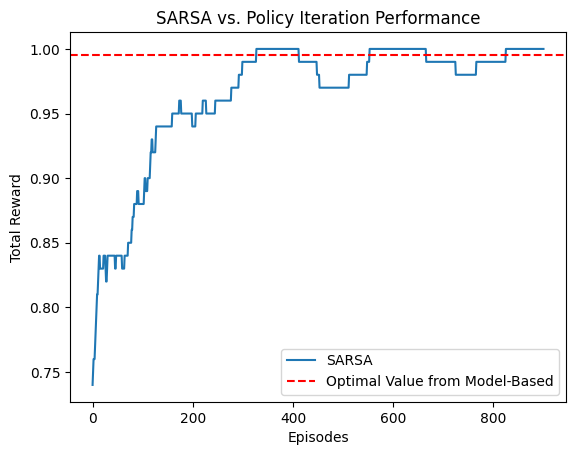

In [102]:
plt.plot(sarsa_rewards, label="SARSA")
plt.axhline(V[0], color='r', linestyle='--', label="Optimal Value from Model-Based")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("SARSA vs. Policy Iteration Performance")
plt.legend()
plt.show()

## Conclusion

We see that the model based policy iteration algorithm clearly outperforms the SARSA model-free algorithm, due to the fact that it has access to the full environment model
and thus converges to the optimal policy as the transition probabilities used correspond to the true environment.

The SARSA algorithm, on the other hand, has to learn the environment model through interactions with the environment, which can be slow and inefficient,
and uses the expected reward to update the Q-values, and thus takes longer (but still converges due to the lower bound of the epsilon decay).
However, the SARSA algorithm is more general and can be applied to environments where the environment model and therefore the transition probabilities
are not known or when no underlying assumptions are made about the environment.


The main difference between the two can easily be noticed in the lines:

```python
q_values[a] = sum(p * (r + gamma * V[s_]) for p, s_, r, _ in env.P[s][a])
```
and
```python
V[s] = sum(policy[s, a] * sum(
    p * (r + gamma * V[s_]) for p, s_, r, _ in env.P[s][a]
) for a in range(env.action_space.n))
```

where the model-based policy iteration algorithm uses the true transition probabilities `p` from the environment model `env.P[s][a]` to calculate the expected reward,
and SARSA uses:

```python
td_target += self.gamma * self.q_table[next_state, next_action]
```
which is the expected reward from the Q-table, updated according to each new observation rather than the true transition probabilities.